# Experiment on AAI Model Architectures
- Created: 10 Mar 2020
- Data: param_draft2
- Increase data size and change model architecture
- Remove SE
- expeirment 10 11

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from time import time
from datetime import datetime
import shutil 
import argparse
from functools import partial
import pickle
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, GRU, InputLayer, AlphaDropout, Activation, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, LSTM, Conv1D, SpatialDropout1D, Concatenate, Multiply, Add

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
tf.random.set_seed(42)

## Metric Function

In [4]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis = 0) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis = 0)), axis = 0) 
    return K.mean(1 - (SS_res/SS_tot), axis=0)

## Utility Functions

In [5]:
#Function for preprocessing data
def delete_params(params):
    '''
    This function remove JX, WC, TRX, TRY, and MS1,2,3 paramter
    '''
    DEL_PARAMS_LIST = [2,8,15,16,21,22,23]
    return np.delete(params,DEL_PARAMS_LIST , axis=1)

In [6]:
def compute_rmse(actual,pred, axis=1):
    # Compute RMSE by row (axis=1) result in rmse of each data
    # Compute RMSE by column (axis=0) result in rmse of each label
    return np.sqrt((np.square(actual - pred)).mean(axis=axis))

In [7]:
def evaluate_model(y_pred, label):
    y_pred = enc.inverse_transform(y_pred)
    label = enc.inverse_transform(label)
#     print('Confusion Matrix')
#     print(confusion_matrix(label, y_pred))
    print('Classification Report')
    print(classification_report(label, y_pred))

In [8]:
def compute_se(actual,pred):
    return np.sqrt((np.square(actual - pred)))

## Load Data 

In [9]:
def prep_data():

    # load data from preprocess pipeline
    dataset = np.load(join('../../data/d_dataset_p2/prep_data_13','training_subsets.npz'))
    X_train =dataset['X_train']
    y_train= dataset['y_train']
    z_train= dataset['z_train']
    X_val = dataset['X_val']
    y_val = dataset['y_val']
    z_val = dataset['z_val']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    z_test = dataset['z_test']
    a_test = dataset['audio_test']
    a_val = dataset['audio_val']
    
    y_train = delete_params(y_train)
    y_val = delete_params(y_val)
    y_test = delete_params(y_test)

    print('Train features and labels %s %s'%(str(X_train.shape),str(y_train.shape)))
    print('Validating features and labels %s %s'%(str(X_val.shape),str(y_val.shape)))
    print('Test features and labels %s %s'%(str(X_test.shape),str(y_test.shape)))

    return X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val = prep_data()

Train features and labels (76260, 24, 39) (76260, 17)
Validating features and labels (9340, 24, 39) (9340, 17)
Test features and labels (9338, 24, 39) (9338, 17)


In [11]:
print(set(z_test))

{'2', 'u', 'y', 'o', 'i', '9', 'O', 'A', '@', 'a', 'e', 'U', 'E:', 'E'}


In [12]:
print('Train features and labels {} {} {}'.format(str(X_train.shape),str(y_train.shape),str(z_train.shape)))
print('Validating features and labels {} {} {}'.format(str(X_val.shape),str(y_val.shape),str(z_val.shape)))
print('Test features and labels {} {} {}'.format(str(X_test.shape),str(y_test.shape),str(z_test.shape)))

Train features and labels (76260, 24, 39) (76260, 17) (76260,)
Validating features and labels (9340, 24, 39) (9340, 17) (9340,)
Test features and labels (9338, 24, 39) (9338, 17) (9338,)


### One-hot label 

In [13]:
z_train_oe=z_train.reshape(-1,1)
z_val_oe=z_val.reshape(-1,1)
z_test_oe=z_test.reshape(-1,1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(z_train_oe)

z_train_oe = enc.transform(z_train_oe).toarray()
z_test_oe = enc.transform(z_test_oe).toarray()
z_val_oe = enc.transform(z_val_oe).toarray()

## 1.) Train Baseline Model
- Model without embedding feature

### Defined Model without Embedded Feature

In [14]:
N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet(feature_layer=1, cnn_unit=64, first_kernel=11, res_unit=64, res_kernel=3,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):


    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x
    
    def residual_block(input_x):
        x = pConv1D(res_unit, kernel_size=res_kernel)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        x = pConv1D(res_unit, kernel_size=res_kernel)(x)
        x = BatchNormalization()(x)
        x = keras.layers.Add()([x, input_x])
        output = Activation(activation_fn)(x)
        return output

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def se_res_block(input_x):
        res_x = residual_block(input_x)
        se_x = se_block(res_x)
        x = layers.Multiply()([res_x, se_x])
        return x

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        x = cnn_block(input_x, cnn_unit, first_kernel)
        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

In [15]:
model = init_senet()(24, 39)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 64)       27520       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 64)       256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 64)       0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile Model 

In [17]:
model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [18]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [19]:
history = model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/100
76260/76260 [==============================] - 24s 311us/sample - loss: 0.1088 - rmse: 0.3078 - R2: 0.5618 - val_loss: 0.0442 - val_rmse: 0.1932 - val_R2: 0.8201
Epoch 2/100
76260/76260 [==============================] - 14s 184us/sample - loss: 0.0630 - rmse: 0.2314 - R2: 0.7454 - val_loss: 0.0398 - val_rmse: 0.1816 - val_R2: 0.8389
Epoch 3/100
76260/76260 [==============================] - 14s 184us/sample - loss: 0.0550 - rmse: 0.2141 - R2: 0.7784 - val_loss: 0.0389 - val_rmse: 0.1804 - val_R2: 0.8433
Epoch 4/100
76260/76260 [==============================] - 14s 185us/sample - loss: 0.0509 - rmse: 0.2055 - R2: 0.7949 - val_loss: 0.0359 - val_rmse: 0.1738 - val_R2: 0.8554
Epoch 5/100
76260/76260 [==============================] - 14s 185us/sample - loss: 0.0485 - rmse: 0.2003 - R2: 0.8044 - val_loss: 0.0345 - val_rmse: 0.1697 - val_R2: 0.8600
Epoch 6/100
76260/76260 [==============================] - 14s 185us/sample - los

In [20]:
model.save('model_baseline.hdf5')

### Evaluation 

In [21]:
model.evaluate(X_test,y_test,verbose=0)

[0.02536442904505926, 0.14339672, 0.8905086]

In [22]:
y_pred = model.predict(X_test)

In [23]:
err = compute_rmse(y_test,y_pred, axis=0)

In [24]:
print(err)

[0.16194154 0.13497644 0.12880892 0.14495559 0.16120693 0.20821488
 0.2171956  0.10638557 0.12369659 0.15653774 0.16296486 0.14184149
 0.14496596 0.19481928 0.15752185 0.15270784 0.16652579]


## 2.) Trained Embedding Layer 

### Defined Embedding Model

In [25]:
PHONETIC_OUTPUT = len(set(z_train))
EMBEDDED_FEATURE = 39

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)

def embeded_model(input_shape_1,input_shape_2):
    inputs = keras.Input(shape=(input_shape_1,input_shape_2))
    x = pLSTM(EMBEDDED_FEATURE)(inputs)
    x = Flatten()(x)
    outputs = Dense(PHONETIC_OUTPUT, activation='softmax', kernel_initializer='he_uniform')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [26]:
embedded = embeded_model(24, 39)
embedded.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 39)            12324     
_________________________________________________________________
flatten (Flatten)            (None, 936)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                13118     
Total params: 25,442
Trainable params: 25,442
Non-trainable params: 0
_________________________________________________________________


### Compile Model 

In [27]:
embedded.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

### Train Model 

In [28]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [29]:
history = embedded.fit(X_train,z_train_oe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,z_val_oe),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/100
76260/76260 [==============================] - 6s 74us/sample - loss: 2.0143 - accuracy: 0.7720 - val_loss: 1.8802 - val_accuracy: 0.8880
Epoch 2/100
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8968 - accuracy: 0.8678 - val_loss: 1.8532 - val_accuracy: 0.9080
Epoch 3/100
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8734 - accuracy: 0.8886 - val_loss: 1.8419 - val_accuracy: 0.9184
Epoch 4/100
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8600 - accuracy: 0.9009 - val_loss: 1.8391 - val_accuracy: 0.9200
Epoch 5/100
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8515 - accuracy: 0.9089 - val_loss: 1.8316 - val_accuracy: 0.9285
Epoch 6/100
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8445 - accuracy: 0.9155 - val_loss: 1.8294 - val_accuracy: 0.9293
Epoch 7/100
76260/76260 [==========================

In [30]:
embedded.save('embedded.hdf5')

### Evaluated Model 

In [31]:
z_pred = embedded.predict(X_test)
evaluate_model(z_pred, z_test_oe)

Classification Report
              precision    recall  f1-score   support

           2       0.93      0.96      0.94       701
           9       0.96      0.98      0.97       688
           @       0.96      0.94      0.95       635
           A       0.94      0.95      0.94       645
           E       0.92      0.94      0.93       697
          E:       0.94      0.94      0.94       655
           O       0.91      0.94      0.92       729
           U       0.91      0.89      0.90       687
           a       0.95      0.94      0.95       689
           e       0.93      0.93      0.93       644
           i       0.97      0.92      0.94       684
           o       0.95      0.87      0.91       634
           u       0.89      0.95      0.92       659
           y       0.93      0.92      0.93       591

    accuracy                           0.93      9338
   macro avg       0.93      0.93      0.93      9338
weighted avg       0.93      0.93      0.93      9338



## 3.) Model with Embedding Feature 

### Embedded input model

In [32]:
embedded = tf.keras.models.load_model('embedded.hdf5')

embedded_layers = tf.keras.Sequential()
for layer in embedded.layers[:-2]:
    layer.trainable = False
    embedded_layers.add(layer)
embedded_layers.summary()

N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet_w_emb(feature_layer=1, cnn_unit=64, first_kernel=11, res_unit=64, res_kernel=3,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):

    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x
    
    def residual_block(input_x):
        x = pConv1D(res_unit, kernel_size=res_kernel)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        x = pConv1D(res_unit, kernel_size=res_kernel)(x)
        x = BatchNormalization()(x)
        x = keras.layers.Add()([x, input_x])
        output = Activation(activation_fn)(x)
        return output

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def se_res_block(input_x):
        res_x = residual_block(input_x)
        se_x = se_block(res_x)
        x = layers.Multiply()([res_x, se_x])
        return x

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        embedded = embedded_layers(input_x)
        x = layers.Concatenate()([input_x, embedded])
        x = cnn_block(input_x, cnn_unit, first_kernel)

        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 39)            12324     
Total params: 12,324
Trainable params: 0
Non-trainable params: 12,324
_________________________________________________________________


In [33]:
emb_model = init_senet_w_emb()(24, 39)
emb_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 64)       27520       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 24, 64)       256         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 24, 64)       0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

### Compile Model 

In [34]:
emb_model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [35]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [36]:
history = emb_model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/100
76260/76260 - 22s - loss: 0.1113 - rmse: 0.3109 - R2: 0.5505 - val_loss: 0.0460 - val_rmse: 0.1990 - val_R2: 0.8124
Epoch 2/100
76260/76260 - 14s - loss: 0.0629 - rmse: 0.2319 - R2: 0.7451 - val_loss: 0.0391 - val_rmse: 0.1801 - val_R2: 0.8426
Epoch 3/100
76260/76260 - 14s - loss: 0.0544 - rmse: 0.2136 - R2: 0.7800 - val_loss: 0.0354 - val_rmse: 0.1731 - val_R2: 0.8572
Epoch 4/100
76260/76260 - 14s - loss: 0.0506 - rmse: 0.2055 - R2: 0.7955 - val_loss: 0.0358 - val_rmse: 0.1730 - val_R2: 0.8552
Epoch 5/100
76260/76260 - 14s - loss: 0.0481 - rmse: 0.2000 - R2: 0.8056 - val_loss: 0.0330 - val_rmse: 0.1668 - val_R2: 0.8668
Epoch 6/100
76260/76260 - 14s - loss: 0.0462 - rmse: 0.1959 - R2: 0.8131 - val_loss: 0.0317 - val_rmse: 0.1636 - val_R2: 0.8720
Epoch 7/100
76260/76260 - 14s - loss: 0.0446 - rmse: 0.1925 - R2: 0.8197 - val_loss: 0.0311 - val_rmse: 0.1629 - val_R2: 0.8749
Epoch 8/100
76260/76260 - 14s - loss: 0.0436 - rmse: 0.

In [37]:
emb_model.save('model_with_embedded.hdf5')

## 4.) Evaluation 

In [38]:
emb_model = tf.keras.models.load_model('model_with_embedded.hdf5', custom_objects={'rmse': rmse, 'R2':R2})

In [39]:
emb_model.evaluate(X_test,y_test,verbose=0)

[0.025251392964461192, 0.14263831, 0.8890895]

In [40]:
y_pred = emb_model.predict(X_test)

### Check error by each data 

In [41]:
errs = compute_rmse(y_test,y_pred, axis=1)

In [42]:
print(err)

[0.16194154 0.13497644 0.12880892 0.14495559 0.16120693 0.20821488
 0.2171956  0.10638557 0.12369659 0.15653774 0.16296486 0.14184149
 0.14496596 0.19481928 0.15752185 0.15270784 0.16652579]


### Error rank by highest 

In [43]:
err_df = pd.DataFrame({'phonetic':z_test, 'err':errs})

In [44]:
err_df.head()

,phonetic,err
0,U,0.119356
1,O,0.291823
2,O,0.151927
3,U,0.070151
4,i,0.127706


In [45]:
err_df.sort_values('err')

,phonetic,err
8035,a,0.032212
9318,E,0.034436
5071,A,0.034988
1258,a,0.036122
487,A,0.038854
...,...,...
6036,E,0.625002
3950,U,0.632457
5687,U,0.635934
89,U,0.653842


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D4333FD908>]],
      dtype=object)

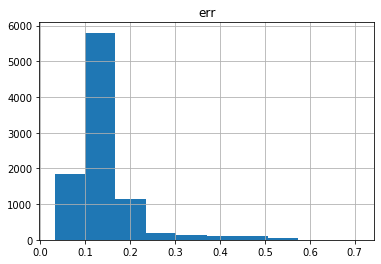

In [46]:
err_df.hist('err')

In [47]:
err_df_high = err_df[err_df['err'] > 0.15]

In [48]:
err_df_high.head()

,phonetic,err
1,O,0.291823
2,O,0.151927
5,y,0.160038
6,i,0.183955
8,i,0.205061


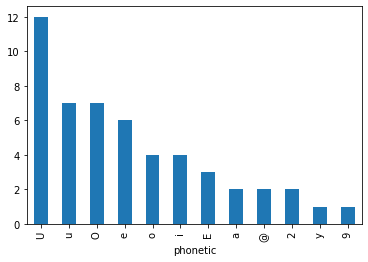

In [49]:
err_df[err_df['err'] > 0.5].groupby('phonetic')['phonetic'].count().sort_values(ascending=False).plot.bar()

In [50]:
err_df_high.groupby('phonetic')['phonetic'].count()

phonetic
2     100
9     179
@     212
A      97
E     225
E:    191
O     215
U     140
a     210
e     238
i     329
o     192
u     252
y     159
Name: phonetic, dtype: int64

## Evaluate each param of each row

In [51]:
se = compute_se(y_test,y_pred)
errs = compute_rmse(y_test,y_pred, axis=1)

In [52]:
df_se = pd.DataFrame(se, columns=["HX","HY","JA","LP","LD","VS","VO","TCX","TCY","TTX","TTY","TBX","TBY","TS1","TS2","TS3","TS4"])

In [53]:
df_se['phonetic'] = z_test
df_se['mean_err'] = errs
df_se['audio'] = a_test

In [54]:
df_se.head()

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.106796,0.156995,0.020267,0.048870,0.121968,0.022292,0.396976,0.047706,0.091172,0.034469,0.088316,0.071373,0.039106,0.038163,0.027247,0.034178,0.028261,U,0.119356,"[-0.0036667322, -0.0067870035, -0.009936802, -..."
1,0.421400,0.276770,0.176993,0.170226,0.393636,0.294811,0.294975,0.082096,0.155937,0.267452,0.098560,0.278880,0.303437,0.365536,0.329519,0.494084,0.189483,O,0.291823,"[-0.0077388003, -0.011906635, -0.15257795, -0...."
2,0.043133,0.091274,0.038767,0.126134,0.178741,0.215122,0.262871,0.189747,0.296608,0.004877,0.107300,0.011007,0.170243,0.198044,0.041915,0.063391,0.088560,O,0.151927,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.108815,0.011169,0.028320,0.022134,0.019730,0.076508,0.083298,0.005115,0.071705,0.058917,0.106762,0.062005,0.095641,0.107754,0.054902,0.097788,0.001995,U,0.070151,"[0.026149532, 0.034463353, 0.037094187, 0.0368..."
4,0.072459,0.099061,0.170661,0.166349,0.187937,0.010204,0.170254,0.008540,0.030086,0.026878,0.119259,0.105838,0.060074,0.059379,0.099471,0.117612,0.288087,i,0.127706,"[-0.021888198, -0.033991054, -0.042626306, -0...."


In [55]:
df_se[(df_se['phonetic'] == '7') & (df_se['mean_err'] > 0.5)]['TS4'].plot.hist()

TypeError: no numeric data to plot

## EDA audio of testing data 

In [ ]:
df_se_sort = df_se.sort_values('mean_err',ascending=False)
df_se_sort.reset_index(drop=True, inplace=True)

In [ ]:
df_se_sort[df_se_sort['phonetic'] == '&'].head(n=5)

In [ ]:
Audio(df_se_sort['audio'][0], rate=16000)

In [ ]:
df_se_sort[df_se_sort['phonetic'] == '&'].tail(n=5)

In [ ]:
Audio(df_se_sort['audio'][12073], rate=16000)